# Required installations 

In [ ]:
#!pip install torch
#!pip install tensorflow
#!pip install keras
#!pip install keras-rl2
#!pip install gym
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install stable_baselines3[extra]
#!pip install pygame

# Important imports 

In [1]:
import gymnasium as gym
from stable_baselines3 import DDPG, TD3, A2C, PPO
from stable_baselines3.common.noise import NormalActionNoise #importing Gaussian Noise
import os
import numpy as np
import torch
from IPython.display import clear_output

# Überprüfen, ob CUDA verfügbar ist
if torch.cuda.is_available():
    print('CUDA ist verfügbar.')
    print('Aktuelles Gerät:', torch.cuda.current_device())
    print('Gerätename:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('CUDA ist nicht verfügbar.')

CUDA ist verfügbar.
Aktuelles Gerät: 0
Gerätename: NVIDIA GeForce RTX 2070 SUPER


# Initializising environment 

In [ ]:
env = gym.make('Pendulum-v1', g = 9.81, render_mode="rgb_array") #choose gym from https://gymnasium.farama.org/. Choose render mode "rgb_array" or choose "human" to visiualize the game but it will take more time until the action is done
env.reset() #clear the environment

print("sample action", env.action_space.sample()) #Value for action
print("observation space shape", env.observation_space.shape) #Tensor for possible states (In pendulum there are 3 states of the pendulum: x-,y coordinate and angular velocity)
print("sample observation", env.observation_space.sample()) #Actual values inside the Tensor (Since there are 3 states of the pendulum, the tensor includes 3 values of the states)


# Let the game be played without any sense 
## (Don't forget "human" Render Mode)

In [ ]:
episodes = 10 #initialise for loop
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0

    while not done: #what to do in the for loop
        env.render() #render the process
        action = env.action_space.sample() #what action can be taken
        n_state, reward, terminated, truncated, info = env.step(action) #return of the parameters
        score += reward #sum of the reward
        done = terminated or truncated
        
    print("Episode:{} Score:{}".format(episode, score)) #print the number and the reward of the episode
    print("sample action", env.action_space.sample()) #Value for action
    print("sample observation", env.observation_space.sample()) #Actual values inside the Tensor (Since there are 3 states of the pendulum, the tensor includes 3 values of the states)

env.close()

In [ ]:
env.close()

# Building, training and saving a Model

In [ ]:
models_dir = "models/Test" #making a Folder in your explorer with the data , dont forget to name your folder according to your model name
logdir = "logs" 

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)
    
env.reset()

n_actions = env.action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = DDPG("MlpPolicy", env, verbose = 1, tensorboard_log=logdir, action_noise=action_noise) #defining model as DDPG/TD3/A2C/PPO Model with given policy, environment, verbose = 1 for returning infos, sending infos to tensorboard and the noise for better exploration
#action_noise=action_noise cannot be applied to stochastic models like A2C or PPO!
TIMESTEPS = 10000 #defining when a model will be saved, in this case every 10000 steps
iters = 0
for i in range(20): #for 20 times 10000 = 200000 steps the model will learn.
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="Test") #change the tb_log_name to create different folders in your explorer
    model.save(f"{models_dir}/{TIMESTEPS*i}")
#to see data in your tensorboard, open a terminal in your corresponding directory and type "tensorboard --logdir=logs" while the model is learning
#to load the data when you closed tensorboard type "tensorboard --logdir path/to/logs"
env.close()

# Load the trained Model

In [ ]:
models_dir = "models/DDPG"
model_path = f"{models_dir}/180000.zip"
logdir = "logs" 

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)
    
env = gym.make('Pendulum-v1', g = 9.81, render_mode="human") 
env.reset() 



model = DDPG.load(model_path, env = env)
print("observation space shape", env.observation_space.shape)
episodes = 10

for ep in range(episodes):
    obs = env.observation_space.sample()
    done = False
    while not done:
        env.render()
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)

In [ ]:
env.close()

# Evaluation of the Model

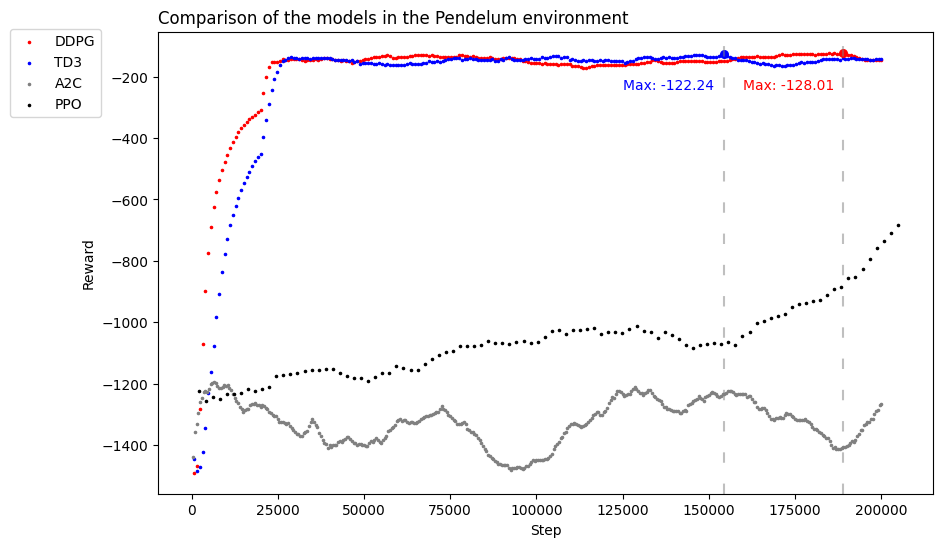

In [8]:
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

df_DDPG = pd.read_csv('logs_DDPG_w_o_noise_03.09.24_0.csv') #define your data logs here
df_TD3 = pd.read_csv('logs_TD3_w_o_noise_03.09.24_0.csv')
df_A2C = pd.read_csv('logs_A2C_03.09.24_0.csv')
df_PPO = pd.read_csv('logs_PPO_03.09.24_0.csv')

plt.figure(figsize=(10, 6))


plt.scatter(df_DDPG.Step, df_DDPG.Value, marker = '.', color = 'red', s = 10, label='DDPG') #DIY your own diagram
plt.scatter(df_TD3.Step, df_TD3.Value, marker = '.', color = 'blue', s = 10, label='TD3')
plt.scatter(df_A2C.Step, df_A2C.Value, marker = '.', color = 'gray', s = 10, label='A2C')
plt.scatter(df_PPO.Step, df_PPO.Value, marker = '.', color = 'black', s = 10, label='PPO')

plt.title('Comparison of the models in the Pendelum environment', loc = 'left')

max_value_DDPG = df_DDPG.Value.max() #defining max values of the data logs to compare the models
max_step_DDPG = df_DDPG[df_DDPG.Value == max_value_DDPG].Step.values[0]
max_value_TD3 = df_TD3.Value.max()
max_step_TD3 = df_TD3[df_TD3.Value == max_value_TD3].Step.values[0]
plt.scatter(max_step_DDPG, max_value_DDPG, color='red', s=30, marker='o')
plt.annotate(f'Max: {max_value_DDPG:.2f}', (max_step_DDPG, max_value_DDPG), xytext=(125000, max_value_DDPG + -120), color = 'blue')
plt.scatter(max_step_TD3, max_value_TD3, color='blue', s=30, marker='o')
plt.annotate(f'Max: {max_value_TD3:.2f}', (max_step_TD3, max_value_TD3), xytext=(160000, max_value_DDPG + -120), color = 'red')
#plt.annotate(f'Max: {max_step_TD3:.2f}', (max_step_TD3, max_value_TD3)) #check step when max reward was recieved
#plt.annotate(f'Max: {max_step_DDPG:.2f}', (max_step_DDPG, max_value_DDPG)) #check step when max reward was recieved
plt.axvline(x=max_step_DDPG, color='gray', linestyle='--', alpha = 0.5, dashes=(5, 10))
plt.axvline(x=max_step_TD3, color='gray', linestyle='--', alpha = 0.5, dashes=(5, 10))


plt.xlabel('Step')
plt.ylabel('Reward')

plt.legend(loc='center left', bbox_to_anchor=(-0.2, 0.91))

plt.show()

#### We are going to compare the different trained models in the Pendulum environment. We can see the recieved reward of the models on the y-axis and the amount of steps taken on the x-axis. The most rewards recieved the TD3 model on approximatly 154000 steps. The second most rewards recieved the DDPG model on approximatly 189000 steps. 
#### Overall the DDPG and the TD3 model learned the Pendulum Environment pretty fast compared to the A2C and the PPO models. Thanks to the actor-critic-architecture of the DDPG and TD3 the agents can remember previous rewards of previous steps and learn from the past. The A2C and PPO agents have no memory by default. That's why the DDPG and TD3 agents learn faster than the A2C and PPO agents.
#### The learning curve of the DDPG and TD3 model are similiar to each over but the learning curve of the DDPG model reached the convergence region faster than the TD3 model. This is because of the delayed critic network of the TD3 Agent (Or Twin Delayed DDPG Agent). In order to prevent greedy decisions of the actor the critic network updates itself less often than the DDPG critic. This can be a advantage in some cases but in this case this delayed the learning curve from reaching the convergence region.
#### Summa summarum the DDPG and the TD3 model learned the environment fast and managed to solve the task. The A2C and PPO models have to be trained more steps in order to learn what to do with the pendulum.

# Using a custom environment

#### Let's explore a custom environment for our next challenge. We'll simulate a Permanent Magnet Synchronous Motor (PMSM) and train two agents, DDPG and TD3, to control the motor's current, with the objective of maximizing torque output. Thankfully clever people have already developed a custom environment for this simulation. In this section, we'll follow the approach outlined on the Gym Electric Motor (GEM) GitHub page. For more detailed information, visit: https://github.com/upb-lea/gym-electric-motor.

In [ ]:
#!pip install gym-electric-motor
clear_output()

In [2]:
import gym_electric_motor as gem
from stable_baselines3.common.callbacks import BaseCallback
from gym_electric_motor.reference_generators import LaplaceProcessReferenceGenerator
from gym_electric_motor.visualization import MotorDashboard
from gym_electric_motor.core import Callback
from gymnasium.spaces import Discrete, Box
from gymnasium.wrappers import FlattenObservation, TimeLimit
from gymnasium import ObservationWrapper
from pathlib import Path

In [3]:
class RewardLogger(Callback):
    """Logs the reward accumulated in each episode"""
    def __init__(self):
        self.step_rewards = []
        self.mean_episode_rewards = []
        dir_path = Path.cwd() / "PMSM_simulation" / "saved_agents"
        dir_path.mkdir(parents=True, exist_ok=True)
        self.fpath = dir_path  / "EpisodeRewards.npy"
        
    def on_step_end(self, k, state, reference, reward, done):
        """Stores the received reward at each step"""
        self.step_rewards.append(reward)
    
    def on_reset_begin(self):
        """Stores the mean reward received in every episode"""
        if len(self.step_rewards) > 0:
            self.mean_episode_rewards.append(np.mean(self.step_rewards))
        self.step_rewards = []
        
    def on_close(self):
        """Writes the mean episode reward of the experiment to a file."""
        np.save(self.fpath, np.array(self.mean_episode_rewards))

class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation. Serves
    the purpose to improve the agent's learning speed.
    
    It changes epsilon to cos(epsilon) and sin(epsilon). This serves the purpose
    to have the angles -pi and pi close to each other numerically without losing
    any information on the angle.
    
    Additionally, this wrapper adds a new observation i_sd**2 + i_sq**2. This should
    help the agent to easier detect incoming limit violations.
    """

    def __init__(self, env, epsilon_idx, i_sd_idx, i_sq_idx):
        """
        Changes the observation space to fit the new features
        
        Args:
            env(GEM env): GEM environment to wrap
            epsilon_idx(integer): Epsilon's index in the observation array
            i_sd_idx(integer): I_sd's index in the observation array
            i_sq_idx(integer): I_sq's index in the observation array
        """
        super(FeatureWrapper, self).__init__(env)
        self.EPSILON_IDX = epsilon_idx
        self.I_SQ_IDX = i_sq_idx
        self.I_SD_IDX = i_sd_idx
        new_low = np.concatenate((self.env.observation_space.low[     
                                  :self.EPSILON_IDX], np.array([-1.]),
                                  self.env.observation_space.low[
                                  self.EPSILON_IDX:], np.array([0.])))
        new_high = np.concatenate((self.env.observation_space.high[
                                   :self.EPSILON_IDX], np.array([1.]),
                                   self.env.observation_space.high[
                                   self.EPSILON_IDX:],np.array([1.])))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation. Adds the new features to the
        observation and removes original epsilon.
        
        """
        cos_eps = np.cos(observation[self.EPSILON_IDX] * np.pi)
        sin_eps = np.sin(observation[self.EPSILON_IDX] * np.pi)
        currents_squared = observation[self.I_SQ_IDX]**2 + observation[self.I_SD_IDX]**2
        observation = np.concatenate((observation[:self.EPSILON_IDX],
                                      np.array([cos_eps, sin_eps]),
                                      observation[self.EPSILON_IDX + 1:],
                                      np.array([currents_squared])))
        return observation


In [4]:
# define motor arguments
motor_parameter = dict(
    p=3,  # [p] = 1, nb of pole pairs
    r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
    l_d=0.37e-3,  # [l_d] = H, d-axis inductance
    l_q=1.2e-3,  # [l_q] = H, q-axis inductance
    psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
)
# supply voltage
u_supply = 400

# Replace the reference generator by passing a new instance
my_new_ref_gen_instance = LaplaceProcessReferenceGenerator(
    reference_state='i_sq',
    sigma_range=(1e-3, 1e-2)
)

# nominal and absolute state limitations
nominal_values=dict(
    omega=418.879, #4000*2*np.pi/60
    i=230,
    u=400 #u_supply
)
limit_values=dict(
    omega=418.879,
    i=345,
    u=400 #u_supply
)

# sampling interval
tau = 1e-5

# define maximal episode steps
max_eps_steps = 10000

motor_initializer = {'random_init': 'uniform', 'interval': np.array([[-230, 230], [-230, 230], [-np.pi, np.pi]])}
reward_function=gem.reward_functions.WeightedSumOfErrors(
    reward_weights={'i_sq': 10, 'i_sd': 10},
    gamma=0.99,  # discount rate 
    reward_power=1
)
reward_logger = RewardLogger()
motor_dashboard = MotorDashboard(state_plots=['i_sq', 'i_sd'], reward_plot=True)
# creating gem environment
env = gem.make(  # define a PMSM with continous action space
    'Cont-CC-PMSM-v0',
    # visualize the results
    visualization=motor_dashboard,
    voltage_supply=u_supply,
    reference_generator=my_new_ref_gen_instance,
    
    # parameterize the PMSM and update limitations
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=motor_initializer,
    ),
    # define the random initialisation for load and motor
    load=dict(
        load_initializer={'random_init': 'uniform', },
    ),
    reward_function=reward_function,
    supply=dict(u_nominal=u_supply),
    # define the duration of one sampling step
    tau=tau,
    callbacks=(reward_logger,),
    ode_solver='euler',
)

env.action_space = Box(low=np.array([-345.0, -345.0, -345.0]), high=np.array([345.0, 345.0, 345.0]), dtype=np.float32)

# applying wrappers
eps_idx = env.physical_system.state_names.index('epsilon')
i_sd_idx = env.physical_system.state_names.index('i_sd')
i_sq_idx = env.physical_system.state_names.index('i_sq')
env = TimeLimit(
    FeatureWrapper(
        FlattenObservation(env), 
        eps_idx, i_sd_idx, i_sq_idx
    ),
    max_eps_steps
)
print(env.action_space)

Box(-345.0, 345.0, (3,), float32)


In [ ]:
buffer_size = 200000 #number of old obsersation steps saved
learning_starts = 10000 # memory warmup
train_freq = 1 # prediction network gets an update each train_freq's step
batch_size = 25 # mini batch size drawn at each update step
policy_kwargs = {
        'net_arch': [64,64] # hidden layer size of MLP
        }
exploration_fraction = 0.1 # Fraction of training steps the epsilon decays 
target_update_interval = 1000 # Target network gets updated each target_update_interval's step
gamma = 0.99
verbose = 1 # verbosity of stable-basline's prints
tau = 1e-5
simulation_time = 5 # seconds
nb_steps = int(simulation_time // tau)

# Überprüfen, ob CUDA verfügbar ist
if torch.cuda.is_available():
    print('CUDA ist verfügbar.')
    print('Aktuelles Gerät:', torch.cuda.current_device())
    print('Gerätename:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('CUDA ist nicht verfügbar.')

In [ ]:
models_dir = "PMSM_simulation/high_ampere/DDPG" #name your directory
logdir = "PMSM_simulation/logs"


if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

total_timesteps = 50000

model = DDPG("MlpPolicy", env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq,#you can decide between TD3 and DDPG Agent
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            verbose=verbose, tensorboard_log=logdir)

for i in range(20): #20 times -> 10mio steps overall
    model.learn(total_timesteps=nb_steps, reset_num_timesteps=False, tb_log_name="DDPG_PMSM_23.09.24_high_ampere")
    model.save(f"{models_dir}/{total_timesteps*i}")

env.close() 
clear_output() #Model will train for 10mio steps, this took approx. 20h

# Evaluating Models with default settings

#### We have trained a DDPG and TD3 model for a simulation of a PMSM with a continous action space. The results look like this:

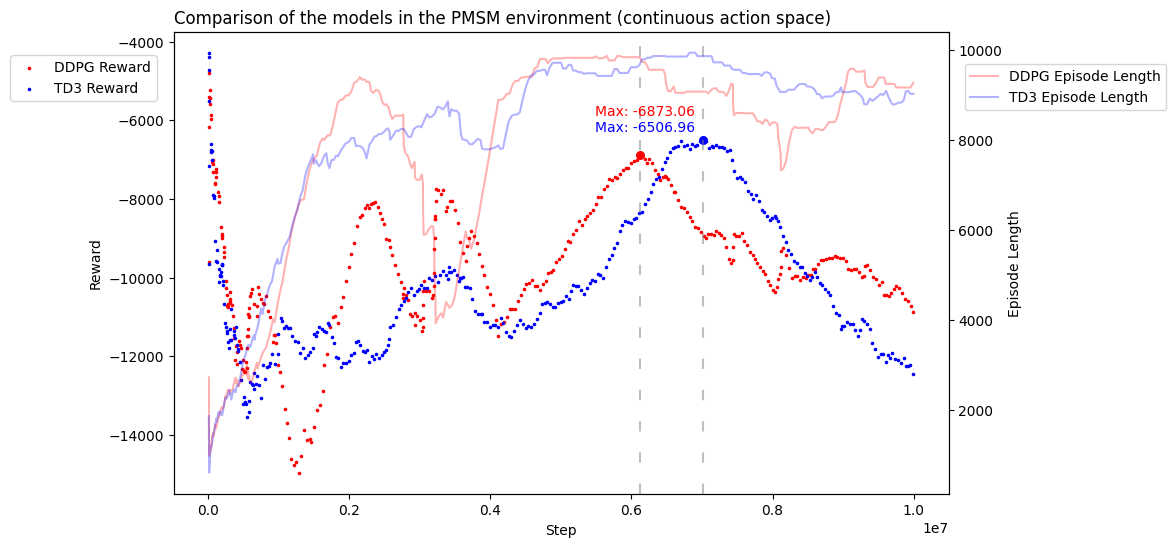

In [9]:
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

df_DDPG_ep = pd.read_csv('DDPG_PMSM_15.09.24_ep_mean.csv') #define your data logs here
df_DDPG_rew = pd.read_csv('DDPG_PMSM_15.09.24_rew_mean.csv')
df_TD3_ep = pd.read_csv('TD3_PMSM_16.09.24_ep_mean.csv')
df_TD3_rew = pd.read_csv('TD3_PMSM_16.09.24_rew_mean.csv')

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot für DDPG und TD3 auf der ersten y-Achse (Reward)
ax1.scatter(df_DDPG_rew.Step, df_DDPG_rew.Value, marker='.', s=10, label='DDPG Reward', color='red')  # DIY your own diagram
ax1.scatter(df_TD3_rew.Step, df_TD3_rew.Value, marker='.', s=10, label='TD3 Reward', color='blue')

ax1.set_xlabel('Step')
ax1.set_ylabel('Reward')
ax1.set_title('Comparison of the models in the PMSM environment (continuous action space)', loc='left')

# Zweite y-Achse für Episode Length
ax2 = ax1.twinx()
ax2.plot(df_DDPG_ep.Step, df_DDPG_ep.Value, color='red',  alpha=0.3, label='DDPG Episode Length')
ax2.plot(df_TD3_ep.Step, df_TD3_ep.Value, color='blue',  alpha=0.3, label='TD3 Episode Length')
ax2.set_ylabel('Episode Length')

# Legende anpassen, um beide Achsen zu berücksichtigen
ax1.legend(loc='center left', bbox_to_anchor=(-0.22, 0.9))
ax2.legend(loc='center right', bbox_to_anchor=(1.29, 0.88))

# Filtern der Daten für x > 0.5e7
df_filtered_DDPG = df_DDPG_rew[df_DDPG_rew['Step'] > 0.5e7]
df_filtered_TD3 = df_TD3_rew[df_TD3_rew['Step'] > 0.5e7]

# Berechnung des maximalen Rewards für DDPG und TD3
max_value_DDPG_rew = df_filtered_DDPG.Value.max()
max_step_DDPG_rew = df_filtered_DDPG[df_filtered_DDPG.Value == max_value_DDPG_rew].Step.values[0]

max_value_TD3_rew = df_filtered_TD3.Value.max()
max_step_TD3_rew = df_filtered_TD3[df_filtered_TD3.Value == max_value_TD3_rew].Step.values[0]

# Anzeige der Maximalwerte im Diagramm
ax1.scatter(max_step_DDPG_rew, max_value_DDPG_rew, color='red', s=30, marker='o')
ax1.annotate(f'Max: {max_value_DDPG_rew:.2f}', (max_step_DDPG_rew, max_value_DDPG_rew), 
             xytext=(0.548e7, max_value_DDPG_rew + 1000), color='red')

ax1.scatter(max_step_TD3_rew, max_value_TD3_rew, color='blue', s=30, marker='o')
ax1.annotate(f'Max: {max_value_TD3_rew:.2f}', (max_step_TD3_rew, max_value_TD3_rew), 
             xytext=(0.548e7, max_value_DDPG_rew + 600), color='blue')

ax1.axvline(x=max_step_DDPG_rew, color='gray', linestyle='--', alpha = 0.5, dashes=(5, 10))
ax1.axvline(x=max_step_TD3_rew, color='gray', linestyle='--', alpha = 0.5, dashes=(5, 10))

plt.show()

#### In this analysis, we compare the performance of different trained models in the PMSM (Permanent Magnet Synchronous Motor) environment. The y-axis represents the reward received by the models, while the x-axis shows the number of steps taken during training. The TD3 model achieved the highest reward at approximately 7 million steps, followed by the DDPG model, which reached its peak reward at around 6.1 million steps.
#### Both the DDPG and TD3 models encountered challenges in maximizing the reward, where a reward of 0 represents the optimal outcome. During the initial phase (up to 4 million steps), both models were focused on exploring the relationship between episode length and received reward. After this point, the episode length for both models converged to approximately 10,000 steps. Following this convergence, the models' received rewards increased, reaching their respective peaks. Beyond these peaks, a downward trend in reward performance was observed, which may be attributed to the models’ attempt to explore alternative strategies for improving rewards.
#### Another notable aspect highlighted in the diagram is the volatility of the DDPG model. Both its reward function and episode length fluctuated significantly, indicating unstable behavior. In contrast, the TD3 model exhibited more stability throughout the training process.
#### In summary, both models demonstrated comparable performance. While the DDPG model reached its peak reward and episode length earlier, the TD3 model displayed greater overall stability during the training period.
#### The next step will involve fine-tuning the training parameters to potentially enhance the performance of both models.

# Hyperparameter Tuning

#### The goal of this section is to help our model to achieve better rewards. In order to improve our model, we will change the hyperparameters of the PMSM model. But which parameters should we change and how do we change them? Are we going to raise the parameter values or lower them? Because of the complexity of the PMSM environment, we would have to do trial and error in order to learn what helps our model and what not. That's why we are going to use automated pipelines. Automated pipelines will help us automatically find the best parameter values while the model is training. The disadvantage of automated pipelines is the increase of the training duration of our models. But nethertheless let's see if automated pipelines help our model to improve.

In [ ]:
#!pip install optuna
#!pip install ipywidgets
clear_output()

In [3]:
import optuna

In [8]:
#Compile this class definition if you want to tune your hyperparameters. It's possible that you have to restart kernel if you want to train models.
class RewardLogger(BaseCallback):
    """Logs the reward accumulated in each episode"""

    def __init__(self, verbose=0):
        super(RewardLogger, self).__init__(verbose)
        self.step_rewards = []
        self.mean_episode_rewards = []
        dir_path = Path.cwd() / "PMSM_simulation" / "saved_agents"
        dir_path.mkdir(parents=True, exist_ok=True)
        self.fpath = dir_path / "EpisodeRewards.npy"

    def set_env(self, env):
        """Set the environment for the callback."""
        self.env = env

    def on_reset_begin(self):
        """Stores the mean reward received in every episode"""
        self.step_rewards = []
        
    def on_close(self):
        """Writes the mean episode reward of the experiment to a file."""
        np.save(self.fpath, np.array(self.mean_episode_rewards))

    def _on_reset_end(self, *args):
        """Handles the reset end callback expected by the environment."""
        pass  # This method is now defined, even if it does nothing.

    def _on_step(self) -> bool:
        """Retrieve the reward for the current step"""
        reward = self.locals['rewards']  # Assuming 'rewards' is accessible
        self.step_rewards.append(reward)

        # If the episode ends, calculate the mean episode reward
        if self.locals['dones']:
            episode_mean_reward = np.mean(self.step_rewards)
            self.mean_episode_rewards.append(episode_mean_reward)
            self.step_rewards = []  # Reset for next episode
        np.save(self.fpath, self.mean_episode_rewards)# Save rewards to file
        return True  # Keep training

    def _on_training_end(self):
        """Save rewards at the end of training."""
        np.save(self.fpath, self.mean_episode_rewards)
        if self.verbose:
            print("Training ended and rewards saved.")




class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation. Serves
    the purpose to improve the agent's learning speed.
    
    It changes epsilon to cos(epsilon) and sin(epsilon). This serves the purpose
    to have the angles -pi and pi close to each other numerically without losing
    any information on the angle.
    
    Additionally, this wrapper adds a new observation i_sd**2 + i_sq**2. This should
    help the agent to easier detect incoming limit violations.
    """

    def __init__(self, env, epsilon_idx, i_sd_idx, i_sq_idx):
        """
        Changes the observation space to fit the new features
        
        Args:
            env(GEM env): GEM environment to wrap
            epsilon_idx(integer): Epsilon's index in the observation array
            i_sd_idx(integer): I_sd's index in the observation array
            i_sq_idx(integer): I_sq's index in the observation array
        """
        super(FeatureWrapper, self).__init__(env)
        self.EPSILON_IDX = epsilon_idx
        self.I_SQ_IDX = i_sq_idx
        self.I_SD_IDX = i_sd_idx
        new_low = np.concatenate((self.env.observation_space.low[     
                                  :self.EPSILON_IDX], np.array([-1.]),
                                  self.env.observation_space.low[
                                  self.EPSILON_IDX:], np.array([0.])))
        new_high = np.concatenate((self.env.observation_space.high[
                                   :self.EPSILON_IDX], np.array([1.]),
                                   self.env.observation_space.high[
                                   self.EPSILON_IDX:],np.array([1.])))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation. Adds the new features to the
        observation and removes original epsilon.
        
        """
        cos_eps = np.cos(observation[self.EPSILON_IDX] * np.pi)
        sin_eps = np.sin(observation[self.EPSILON_IDX] * np.pi)
        currents_squared = observation[self.I_SQ_IDX]**2 + observation[self.I_SD_IDX]**2
        observation = np.concatenate((observation[:self.EPSILON_IDX],
                                      np.array([cos_eps, sin_eps]),
                                      observation[self.EPSILON_IDX + 1:],
                                      np.array([currents_squared])))
        return observation

In [5]:
# define motor arguments
motor_parameter = dict(
    p=3,  # [p] = 1, nb of pole pairs
    r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
    l_d=0.37e-3,  # [l_d] = H, d-axis inductance
    l_q=1.2e-3,  # [l_q] = H, q-axis inductance
    psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
)
# supply voltage
u_supply = 400

# Replace the reference generator by passing a new instance
my_new_ref_gen_instance = LaplaceProcessReferenceGenerator(
    reference_state='i_sq',
    sigma_range=(1e-3, 1e-2)
)

# nominal and absolute state limitations
nominal_values=dict(
    omega=418.879, #4000*2*np.pi/60
    i=230,
    u=400 #u_supply
)
limit_values=dict(
    omega=418.879,
    i=345,
    u=400 #u_supply
)

# sampling interval
tau = 1e-5

# define maximal episode steps
max_eps_steps = 10000

motor_initializer = {'random_init': 'uniform', 'interval': np.array([[-230, 230], [-230, 230], [-np.pi, np.pi]])}
reward_function=gem.reward_functions.WeightedSumOfErrors(
    reward_weights={'i_sq': 10, 'i_sd': 10},
    gamma=0.99,  # discount rate 
    reward_power=1
)
reward_logger = RewardLogger()
motor_dashboard = MotorDashboard(state_plots=['i_sq', 'i_sd'], reward_plot=True)
# creating gem environment
env = gem.make(  # define a PMSM with continous action space
    'Cont-CC-PMSM-v0',
    # visualize the results
    visualization=motor_dashboard,
    voltage_supply=u_supply,
    reference_generator=my_new_ref_gen_instance,
    
    # parameterize the PMSM and update limitations
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=motor_initializer,
    ),
    # define the random initialisation for load and motor
    load=dict(
        load_initializer={'random_init': 'uniform', },
    ),
    reward_function=reward_function,
    supply=dict(u_nominal=u_supply),
    # define the duration of one sampling step
    tau=tau,
    callbacks=(reward_logger,),
    ode_solver='euler',
)

env.action_space = Box(low=np.array([-345.0, -345.0, -345.0]), high=np.array([345.0, 345.0, 345.0]), dtype=np.float32)

# applying wrappers
eps_idx = env.physical_system.state_names.index('epsilon')
i_sd_idx = env.physical_system.state_names.index('i_sd')
i_sq_idx = env.physical_system.state_names.index('i_sq')
env = TimeLimit(
    FeatureWrapper(
        FlattenObservation(env), 
        eps_idx, i_sd_idx, i_sq_idx
    ),
    max_eps_steps
)
print(env.action_space)

Box(-345.0, 345.0, (3,), float32)


In [6]:
buffer_size = 200000 #number of old obsersation steps saved
learning_starts = 10000 # memory warmup
train_freq = 1 # prediction network gets an update each train_freq's step
policy_kwargs = {
        'net_arch': [64,64] # hidden layer size of MLP
        }
exploration_fraction = 0.1 # Fraction of training steps the epsilon decays 
target_update_interval = 1000 # Target network gets updated each target_update_interval's step
verbose = 1 # verbosity of stable-basline's prints
simulation_time = 5 # seconds
nb_steps = int(simulation_time // tau)

# Überprüfen, ob CUDA verfügbar ist
if torch.cuda.is_available():
    print('CUDA ist verfügbar.')
    print('Aktuelles Gerät:', torch.cuda.current_device())
    print('Gerätename:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('CUDA ist nicht verfügbar.')

CUDA ist verfügbar.
Aktuelles Gerät: 0
Gerätename: NVIDIA GeForce RTX 2070 SUPER


In [13]:
models_dir = "PMSM_simulation/Tuning/TD3" #name your directory
logdir = "PMSM_simulation/logs"
total_timesteps=50000


if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

# Definiere die Optimierungsfunktion
def optimize_td3(trial):
    # Zu tunende Hyperparameter
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.9, 0.999)
    batch_size = trial.suggest_int('batch_size', 32, 256)
    tau = trial.suggest_float('tau', 0.001, 0.05)
    
    model = TD3("MlpPolicy", env, #you can decide between TD3 and DDPG Agent
                batch_size=batch_size, gamma=gamma,verbose=0, tensorboard_log=logdir, tau=tau, learning_rate=learning_rate)

    reward_logger = RewardLogger()

    for i in range(10): 
        model.learn(total_timesteps=20000, reset_num_timesteps=False, callback=reward_logger, tb_log_name="TD3_PMSM__high_ampere_tuning_28.09.24")
        model.save(f"{models_dir}/model_trial_{trial.number}_steps_{total_timesteps*(i+1)}")

   # Holen der besten Belohnung aus dem RewardLogger
    if len(reward_logger.mean_episode_rewards) > 0:
        rewards = np.mean(reward_logger.mean_episode_rewards) 
    else:
        rewards = 0.0  # Fallback, falls keine Rewards gesammelt wurden

    # Sicherstellen, dass ein gültiger numerischer Wert zurückgegeben wird
    if np.any(np.isnan(rewards)):
        return 0.0  # Fallback-Wert, falls NaN

    return rewards


# Optuna-Studie erstellen und optimieren
study = optuna.create_study(direction='maximize')
study.optimize(optimize_td3, n_trials=15)

# Die besten Hyperparameter anzeigen
print("Beste Hyperparameter:", study.best_params)

[I 2024-09-28 15:08:16,602] A new study created in memory with name: no-name-0047bda6-08f6-44e8-bf69-2ab0053da835
[I 2024-09-28 15:26:42,545] Trial 0 finished with value: -18.989070892333984 and parameters: {'learning_rate': 0.0002504330727589998, 'gamma': 0.9408668832710867, 'batch_size': 256, 'tau': 0.03258165194325543}. Best is trial 0 with value: -18.989070892333984.
[I 2024-09-28 15:45:57,666] Trial 1 finished with value: -15.407919883728027 and parameters: {'learning_rate': 0.0006721341215754302, 'gamma': 0.9666994592997383, 'batch_size': 95, 'tau': 0.02590302996728291}. Best is trial 1 with value: -15.407919883728027.
[I 2024-09-28 16:05:25,668] Trial 2 finished with value: -18.045833587646484 and parameters: {'learning_rate': 0.0005621844287255635, 'gamma': 0.9726542169760856, 'batch_size': 218, 'tau': 0.011787507436475504}. Best is trial 1 with value: -15.407919883728027.
[I 2024-09-28 16:24:44,764] Trial 3 finished with value: -15.394432067871094 and parameters: {'learning_ra

Beste Hyperparameter: {'learning_rate': 0.00013839421776497046, 'gamma': 0.9482525724197056, 'batch_size': 51, 'tau': 0.01982735288399686}


#### We now got Tuned Hyperparameters. Let's see if our model improves

# Training with tuned Hyperparameters

In [6]:
#Use old Rewardlogger class definition or you will get errors
models_dir = "PMSM_simulation/Tuning/TD3_tuned" #name your directory
logdir = "PMSM_simulation/logs"
total_timesteps=50000

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)


learning_rate = 0.00013839421776497046
gamma = 0.9482525724197056
batch_size = 51
tau = 0.01982735288399686
buffer_size = 200000 
learning_starts = 10000 
train_freq = 1 
policy_kwargs = {
        'net_arch': [64,64] 
        }
exploration_fraction = 0.1 
target_update_interval = 1000 
verbose = 1
simulation_time = 5 # seconds
nb_steps = int(simulation_time // tau)
    
model = TD3("MlpPolicy", env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, batch_size=batch_size, 
            gamma=gamma, policy_kwargs=policy_kwargs, verbose=verbose, tau=tau, learning_rate=learning_rate, tensorboard_log=logdir)

for i in range(20): 
    model.learn(total_timesteps=500000, reset_num_timesteps=False, tb_log_name="TD3_PMSM__high_ampere_tuned_28.09.24")
    model.save(f"{models_dir}/model_steps_{total_timesteps*(i+1)}")

env.close() 

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to PMSM_simulation/logs\TD3_PMSM__high_ampere_tuned_28.09.24_0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.93e+03  |
|    ep_rew_mean     | -7.47e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 3241      |
|    time_elapsed    | 2         |
|    total_timesteps | 7707      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.3e+03   |
|    ep_rew_mean     | -5.56e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 2023      |
|    time_elapsed    | 5         |
|    total_timesteps | 10387     |
| train/             |           |
|    actor_loss      | 1.8       |
|    critic_loss     | 13.5      |
|    learning_rate   | 0.000138  |
|    n_updates       | 386   

KeyboardInterrupt: 

# Evaluating model with tuned parameters

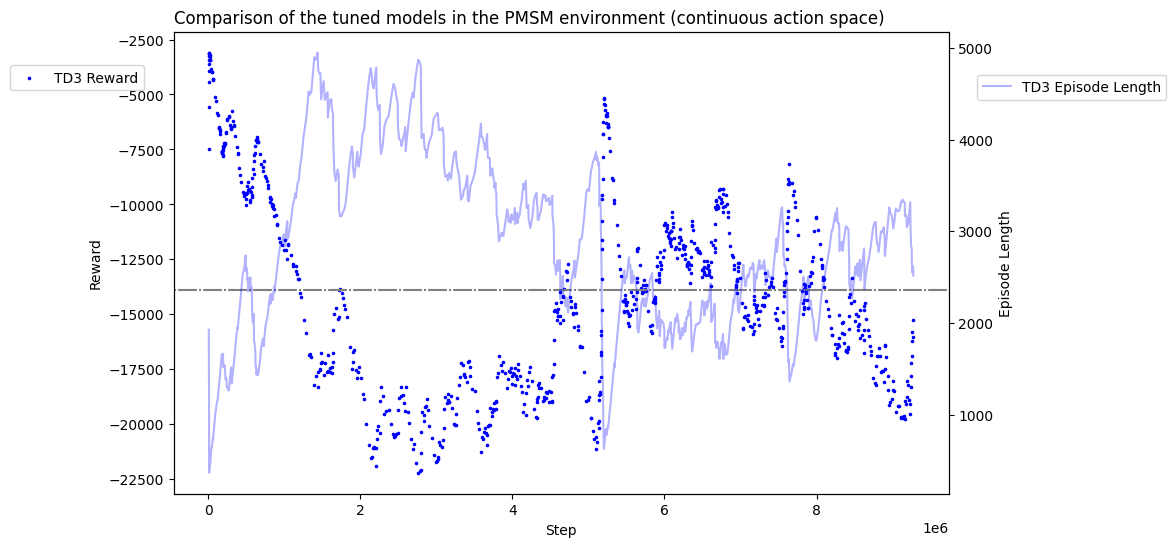

In [38]:
df_TD3_ep = pd.read_csv('TD3_PMSM__high_ampere_tuned_28.09.24_0_mean_rew.csv')
df_TD3_rew = pd.read_csv('TD3_PMSM__high_ampere_tuned_28.09.24_0_mean_ep.csv')

df_TD3_ep = pd.read_csv('TD3_PMSM__high_ampere_tuned_28.09.24_0_mean_ep.csv')
df_TD3_rew = pd.read_csv('TD3_PMSM__high_ampere_tuned_28.09.24_0_mean_rew.csv')

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot für DDPG und TD3 auf der ersten y-Achse (Reward)
#ax1.scatter(df_DDPG_rew.Step, df_DDPG_rew.Value, marker='.', s=10, label='DDPG Reward', color='red')  # DIY your own diagram
ax1.scatter(df_TD3_rew.Step, df_TD3_rew.Value, marker='.', s=10, label='TD3 Reward', color='blue')

ax1.set_xlabel('Step')
ax1.set_ylabel('Reward')
ax1.set_title('Comparison of the tuned models in the PMSM environment (continuous action space)', loc='left')

# Zweite y-Achse für Episode Length
ax2 = ax1.twinx()
#ax2.plot(df_DDPG_ep.Step, df_DDPG_ep.Value, color='red',  alpha=0.3, label='DDPG Episode Length')
ax2.plot(df_TD3_ep.Step, df_TD3_ep.Value, color='blue',  alpha=0.3, label='TD3 Episode Length')
ax2.set_ylabel('Episode Length')

# Legende anpassen, um beide Achsen zu berücksichtigen
ax1.legend(loc='center left', bbox_to_anchor=(-0.22, 0.9))
ax2.legend(loc='center right', bbox_to_anchor=(1.29, 0.88))

# Filtern der Daten für x > 0.5e7
#df_filtered_DDPG = df_DDPG_rew[df_DDPG_rew['Step'] > 0.5e7]
df_filtered_TD3 = df_TD3_rew[df_TD3_rew['Step'] > 0.5e7]

# Berechnung des maximalen Rewards für DDPG und TD3
#max_value_DDPG_rew = df_filtered_DDPG.Value.max()
#max_step_DDPG_rew = df_filtered_DDPG[df_filtered_DDPG.Value == max_value_DDPG_rew].Step.values[0]

max_value_TD3_rew = df_filtered_TD3.Value.max()
max_step_TD3_rew = df_filtered_TD3[df_filtered_TD3.Value == max_value_TD3_rew].Step.values[0]

# Anzeige der Maximalwerte im Diagramm
#ax1.scatter(max_step_DDPG_rew, max_value_DDPG_rew, color='red', s=30, marker='o')
#ax1.annotate(f'Max: {max_value_DDPG_rew:.2f}', (max_step_DDPG_rew, max_value_DDPG_rew), 
             #xytext=(0.548e7, max_value_DDPG_rew + 1000), color='red')

#ax1.scatter(max_step_TD3_rew, max_value_TD3_rew, color='blue', s=30, marker='o')
#ax1.annotate(f'Max: {max_value_TD3_rew:.2f}', (max_step_TD3_rew, max_value_TD3_rew), 
             #xytext=(0.548e7, max_value_DDPG_rew + 600), color='blue')

#ax1.axvline(x=max_step_DDPG_rew, color='gray', linestyle='--', alpha = 0.5, dashes=(5, 10))
#ax1.axvline(x=max_step_TD3_rew, color='gray', linestyle='--', alpha = 0.5, dashes=(5, 10))
ax1.axhline(y=-13900, color='gray', linestyle='--', alpha = 1, dashes=(1, 1, 9, 1))

plt.show()

#### After tuning the TD3 model using the implemented pipeline, the results indicate a distinct symmetry between the rewards and episode length. The adjusted hyperparameters have successfully enhanced the model's reward performance, increasing the average reward from approximately -6500 to -5000. However, this improvement in reward is accompanied by a significant reduction in the mean episode length, which has decreased from around 10,000 steps to 1,000 steps.
#### In order to evaluate the model, we have to clarify the objective of the model. If the primary goal is to optimize for higher rewards, then the tuning has clearly had a positive effect. Conversely, if the objective is to maintain a balance between achieving high rewards and sustaining longer episode lengths (indicating more stable or consistent performance), then the tuning may have adversely impacted the model.